# OsuLearn
##### Machine Learning para jogar mapas de osu!

^^^

Isso aí, tô sem mais nada pra fazer, bora criar uma IA que joga osu! )o)

## Importar umas coisas...

In [1]:
# Machine Learning
import tensorflow as tf
import keras

import numpy as np
import pandas as pd

# Plotagem
import matplotlib.pyplot as plt

# Utilidades
import os
import math

# Lógica do osu!
import osu.beatmap
import osu.replay

import osulearn

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


## Constantes

Aqui tem uns caminhos para os arquivos que precisamos:

In [2]:
# Pasta do osu!
OSU_FOLDER = "C:\\" + os.path.join("Program Files (x86)", "Jogos", "osu!")

## Dados para treinamento...

In [3]:
import osu.replay
import re

from glob import glob, escape

def load_replay_files():
    replay_training_set = []
    pattern = os.path.join(OSU_FOLDER, "Replays", "* Osu.osr")
    for replay_file in glob(pattern):
        info = re.search(r"([^\\/]+) \- (.+ \- .+) \[(.+)\] \((.+)\)", replay_file)
        player, bmap, diff, date = info[1], info[2], info[3], info[4]
        print(player, bmap, diff, date)

        fpat = os.path.join(OSU_FOLDER, "Songs", "**", "*" + escape(bmap) + "*" + escape("[" + diff + "]") + ".osu")

        beatmap_file = glob(fpat)
        if len(beatmap_file) > 0:
            beatmap = osu.beatmap.load(beatmap_file[0])
            if re.search("v14", beatmap.format_version) != None:
                replay = osu.replay.load(replay_file)

                if not (replay.mods & 0x10 or replay.mods & 0x40):
                    replay_training_set.append([beatmap, replay])
                    print("OK", len(replay_training_set) - 1)
                else:
                    print("Replay uses DT or HR. Those mods are not supported yet.")
            else:
                print("Wrong format version")
        else:
            print("Beatmap file not found")
        print()
        
    return replay_training_set

In [18]:
from importlib import reload
reload(osulearn)
reload(osu.replay)

try:
    X = np.load('input_data.npy')
except:
    try:
        replay_training_set
    except NameError:
        replay_training_set = load_replay_files()
    
    print("Processing Input Data...")
    X = osulearn.create_training_data(replay_training_set)
    print()
    np.save('input_data.npy', X)
    
try:
    y = np.load('target_data.npy')
except:
    try:
        replay_training_set
    except NameError:
        replay_training_set = load_replay_files()   
    
    print("Processing Target Data...")
    y = osulearn.create_target_data(replay_training_set)
    
    np.save('target_data.npy', y)

print(X.shape, y.shape)

Processing Target Data...
Freesia
Freesia
Bunny Panic!!!
MRAZ' (feat. Larin)
ninelie (REDSHiFT x Vesuvia remix)
Monochrome Butterfly
Monochrome Butterfly
Destination Calabria
Destination Calabria
Phantasy
Ren-chon no Drum 'n' Bass
Euphoria
Yuima-ru*World TVver.
Yuima-ru*World TVver.
Hanagoyomi short version
Night of Knights
Shine
Star Vs The Forces Of Evil Theme
Chirality
Exit This Earth's Atomosphere
Exit This Earth's Atomosphere
Lone Digger
Weaponized
More One Night (Assertive Hardcore Bootleg) [short ver.]
Nanairo Symphony -TV Size-
Nanairo Symphony -TV Size-
Ghost Rule
Kanata No Reflesia
Allegro Furioso
Allegro Furioso
The Pink Fields
A Grande Familia (TV Size)
Stay Alive
Tokyo Zero Hearts
furioso melodia
Friendly Shop
Zen Zen Zense
Bang Bang
Bang Bang
Harumachi Clover
Harumachi Clover
Uraomote Lovers
Kawaiku Naritai (Short Ver.)
Coloring
True truly love
None
Transform (Original Mix)
Make a Move (Speed Up Ver.)
Warriors
Uta
Yomi yori Kikoyu, Koukoku no Tou to Honoo no Shoujo.
Fatim

## Modelo de rede neural

Agora começa a festa...

In [46]:
import importlib

importlib.reload(keras)
importlib.reload(tf)

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, CuDNNLSTM, CuDNNGRU, concatenate, Input, Reshape, Conv1D, UpSampling1D

REPLAY_FEATURES = ['x', 'y']
MAP_FEATURES = ['x', 'y', 'time_left', 'is_slider', 'is_spinner']

model = Sequential()

map_input = Input(shape=(X.shape[1], X.shape[2]), name='map_info')

out = CuDNNLSTM(32, return_sequences=True)(map_input)

out = Dense(64, activation='linear')(out)
out = Dropout(0.3)(out)

out = Dense(128, activation='linear')(out)
out = Dropout(0.2)(out)

out = Dense(len(REPLAY_FEATURES), activation='linear')(out)
out = Dropout(0.3)(out)

out = Reshape([X.shape[1], len(REPLAY_FEATURES)])(out)

model = Model(inputs=map_input, outputs=out)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
map_info (InputLayer)        (None, 1024, 5)           0         
_________________________________________________________________
cu_dnnlstm_21 (CuDNNLSTM)    (None, 1024, 32)          4992      
_________________________________________________________________
dense_55 (Dense)             (None, 1024, 64)          2112      
_________________________________________________________________
dropout_55 (Dropout)         (None, 1024, 64)          0         
_________________________________________________________________
dense_56 (Dense)             (None, 1024, 128)         8320      
_________________________________________________________________
dropout_56 (Dropout)         (None, 1024, 128)         0         
_________________________________________________________________
dense_57 (Dense)             (None, 1024, 2)           258       
__________

In [6]:
def plot_info(compare):
    %matplotlib inline
    
    plt.ylim((-1, 1))
    for data in compare:
        plt.plot([(x) for x, y in data])
    plt.show()
    
    plt.ylim((-1, 1))
    for data in compare:
        plt.plot([(y) for x, y in data])
    plt.show()
    
#     for data in compare:
#         plt.plot([(a) for distance, angle in data])
#     plt.show()
    
#     for data in compare:
#         plt.plot([(b) for distance, angle in data])
    plt.show()

In [45]:
from random import randint
from sklearn.model_selection import train_test_split

ITERATIONS = 8
EPOCHS = 8

try:
    acc
    loss
except NameError:
    acc = []
    loss = []
    
#model.load_weights("model.hdf5")
for i in range(ITERATIONS):
    print("-" * 80)
    print("Iteration #%d" % (i + 1))
    print("-" * 80)
    print()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randint(0, 100))
    h = model.fit(X_train, y_train, batch_size=len(X_train), epochs=EPOCHS, verbose=1)
    acc += h.history['acc']
    loss += h.history['loss']
    print()

model.save_weights("model.hdf5")

--------------------------------------------------------------------------------
Iteration #1
--------------------------------------------------------------------------------



ValueError: Error when checking target: expected conv1d_1 to have shape (1, 2) but got array with shape (1024, 2)

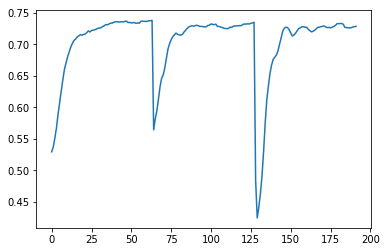

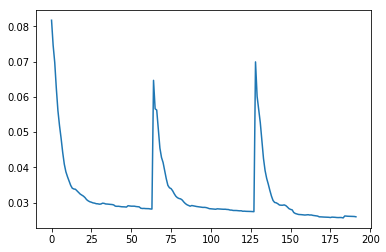

In [21]:
%matplotlib inline

plt.plot(acc)
plt.show()

plt.plot(loss)
plt.show()

0


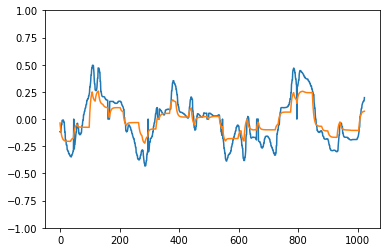

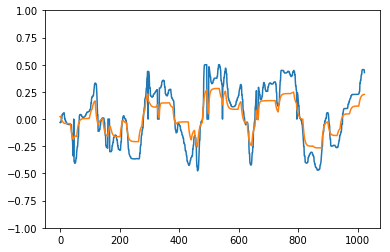

1


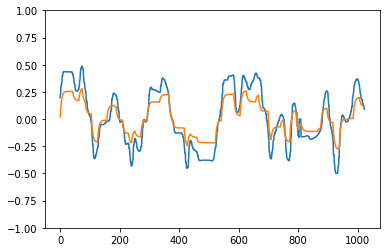

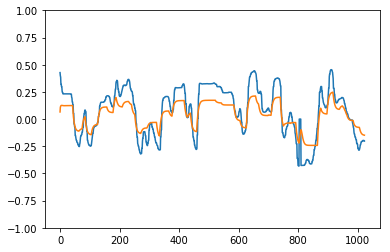

2


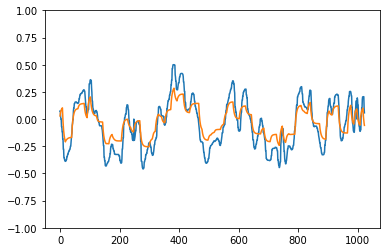

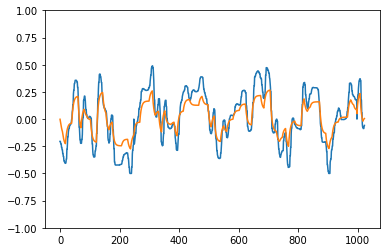

3


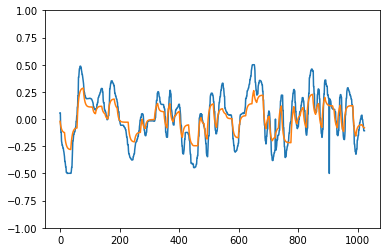

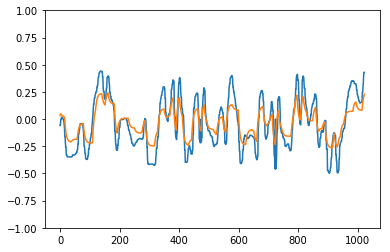

4


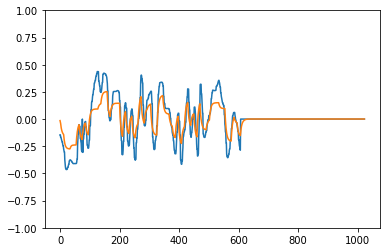

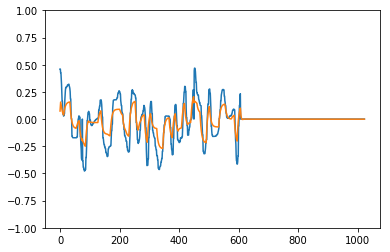

5


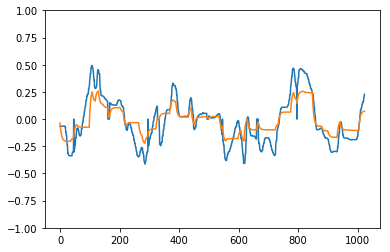

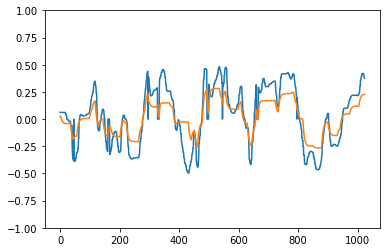

6


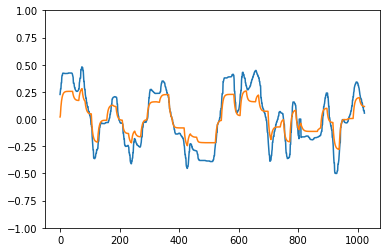

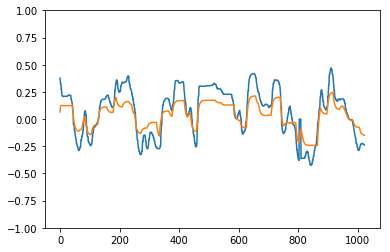

7


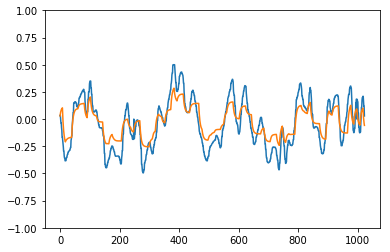

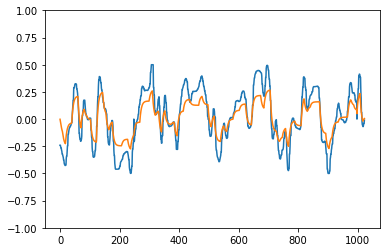

8


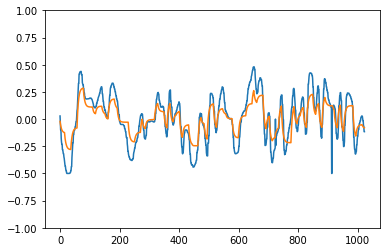

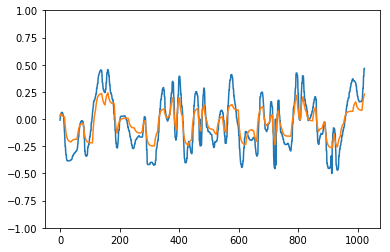

9


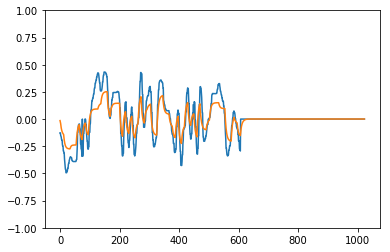

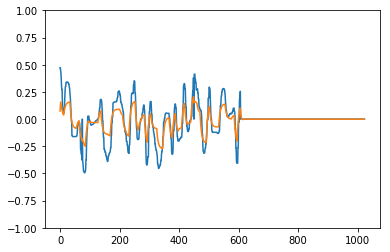

10


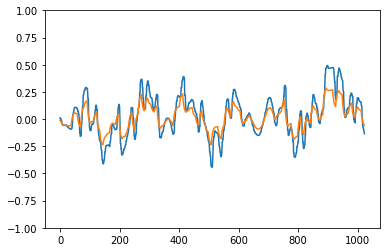

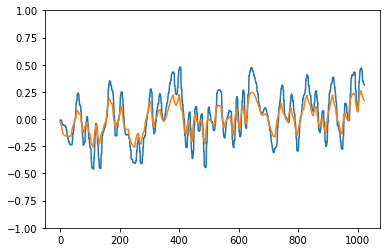

11


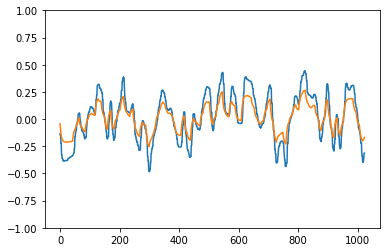

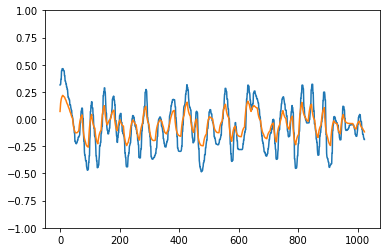

12


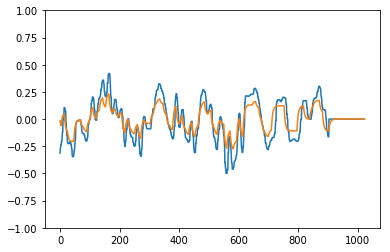

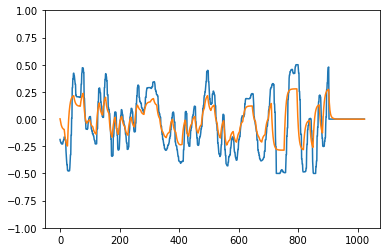

13


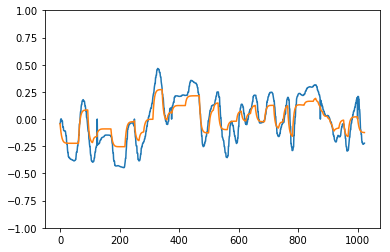

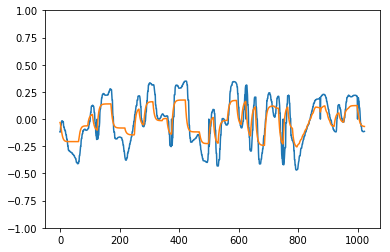

14


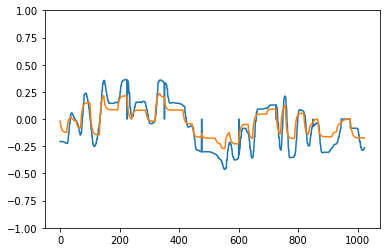

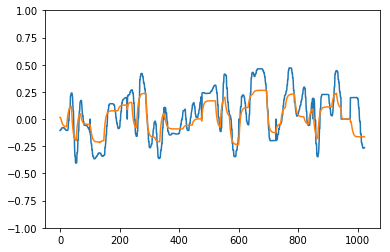

15


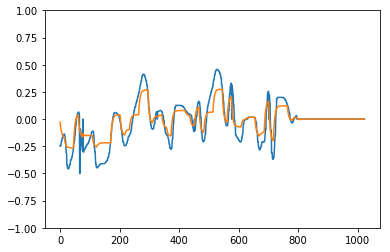

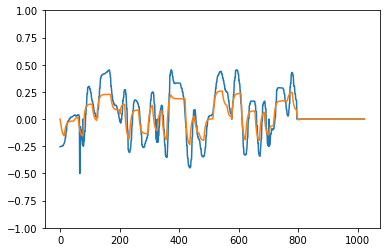

16


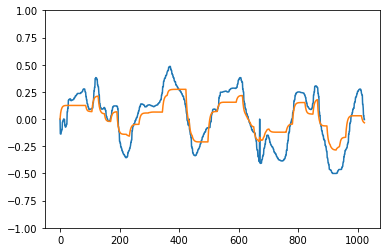

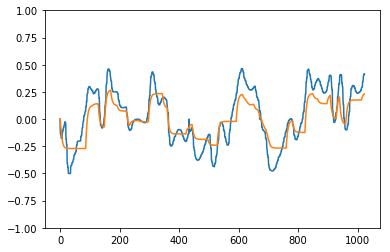

17


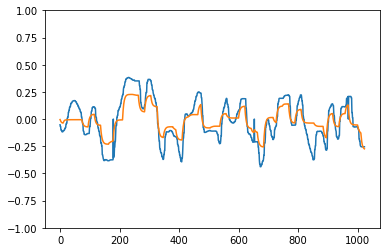

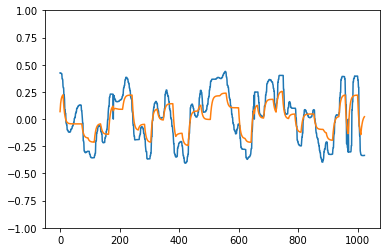

18


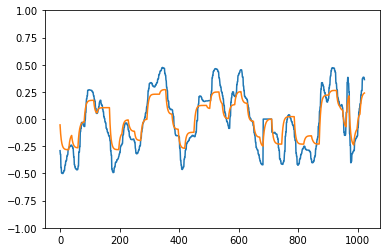

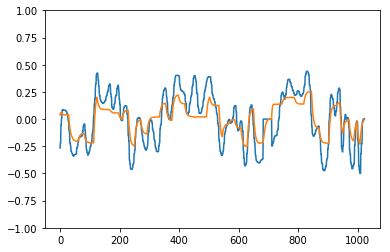

19


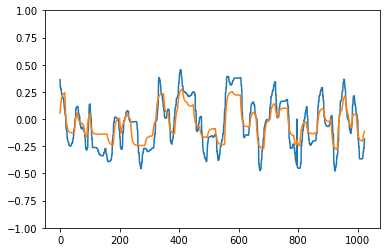

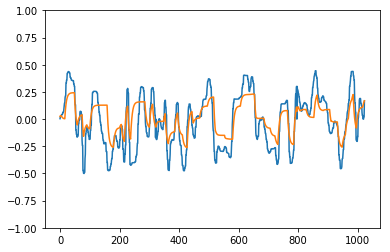

20


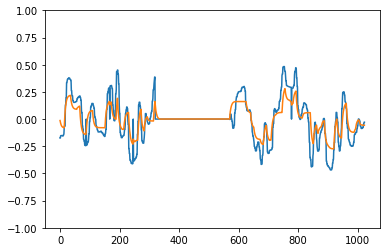

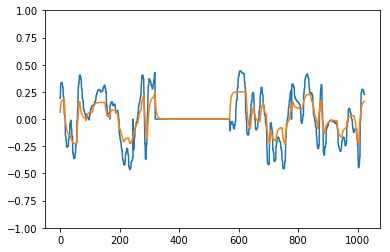

21


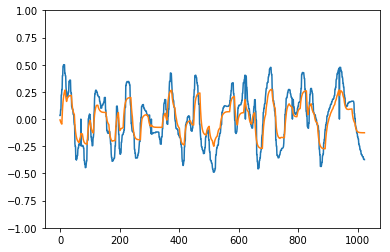

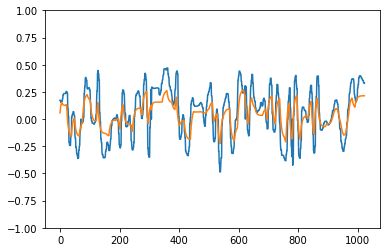

22


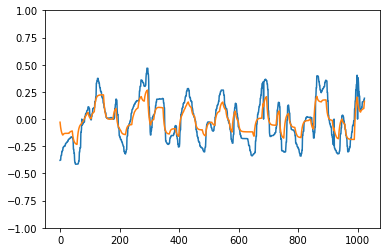

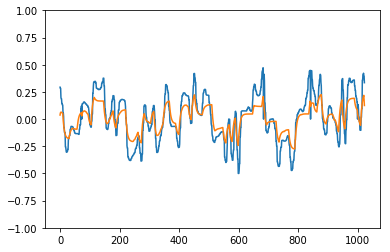

23


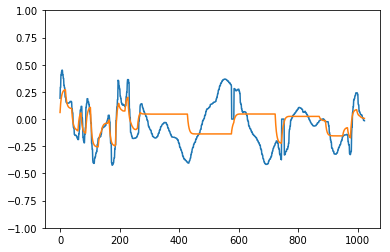

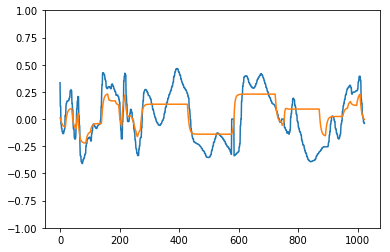

24


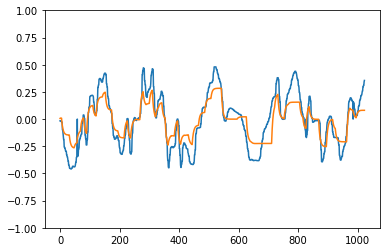

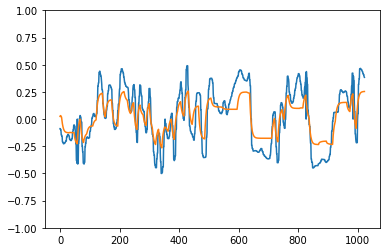

25


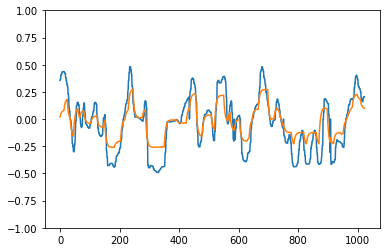

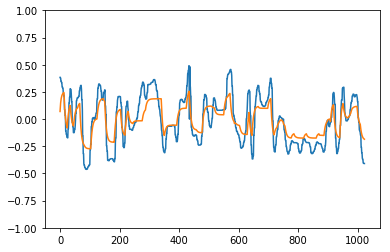

26


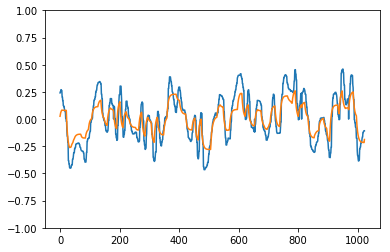

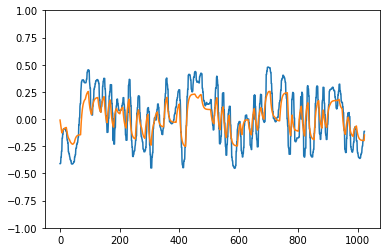

27


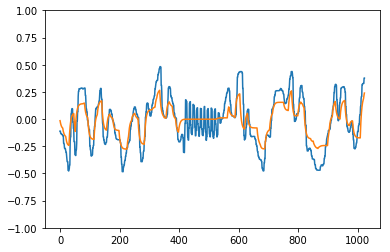

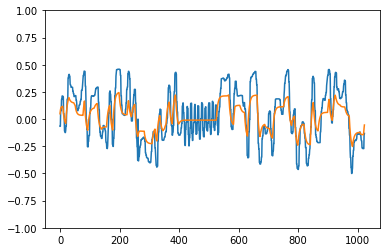

28


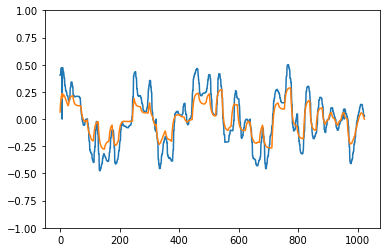

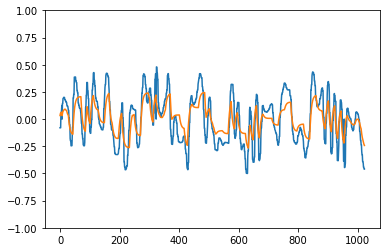

29


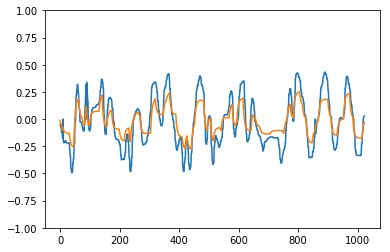

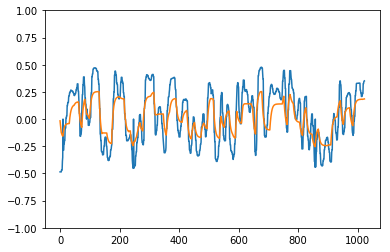

30


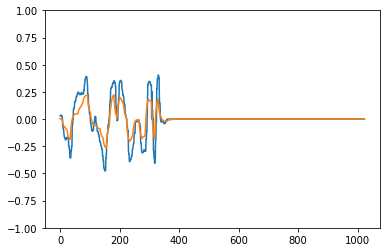

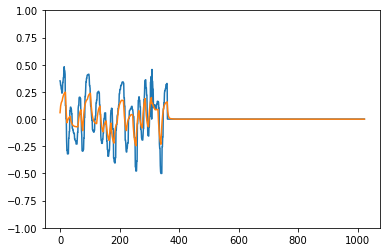

31


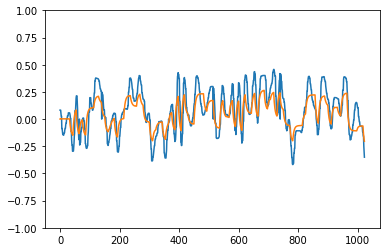

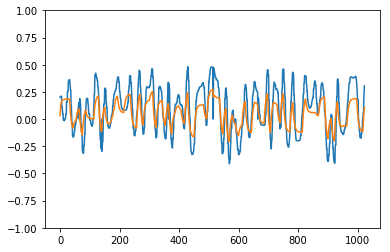

32


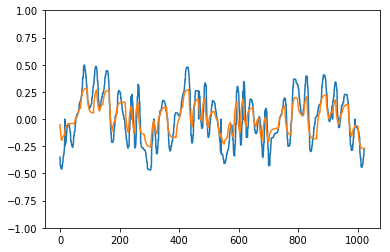

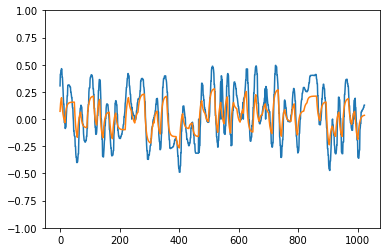

33


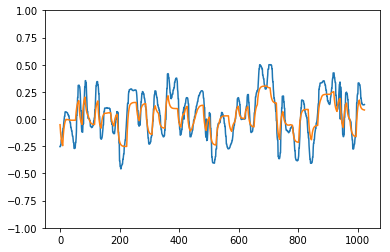

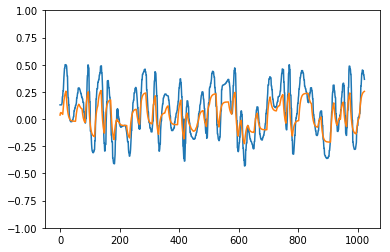

34


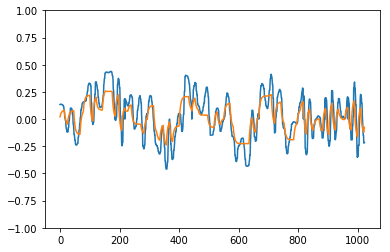

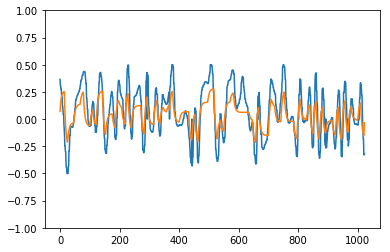

35


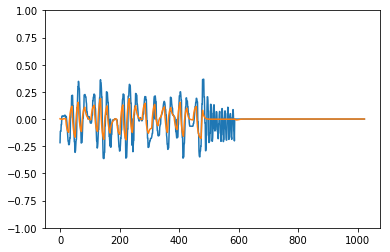

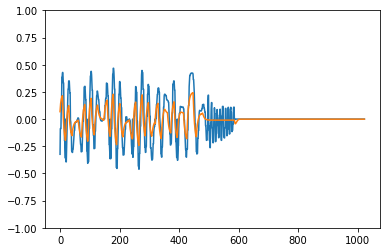

36


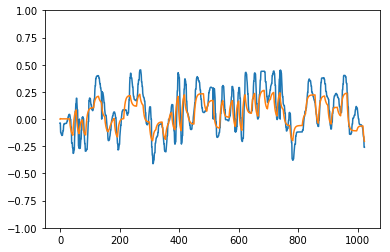

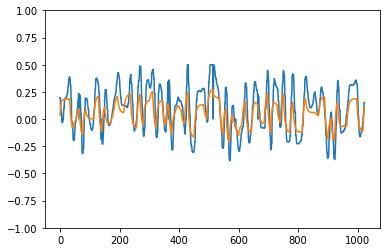

37


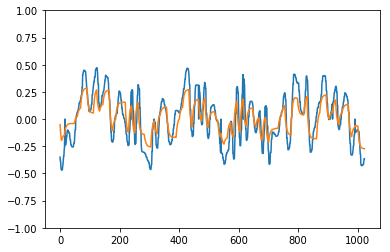

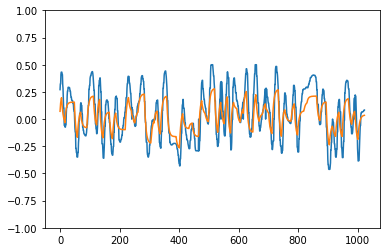

38


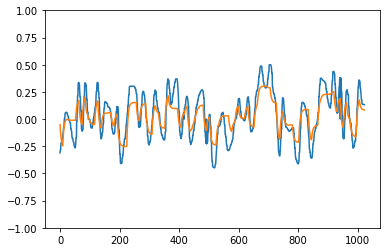

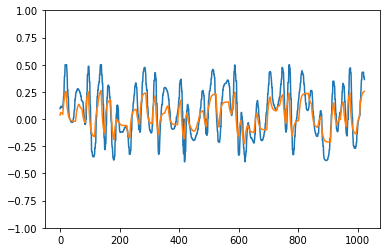

39


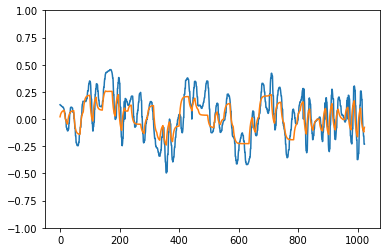

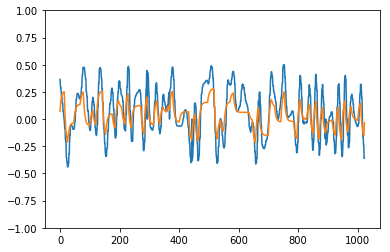

40


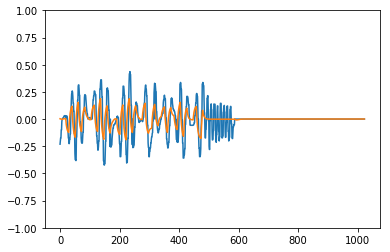

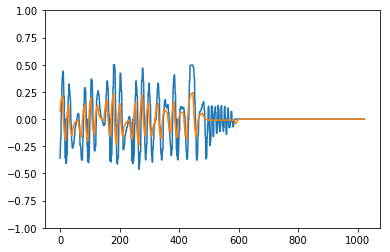

41


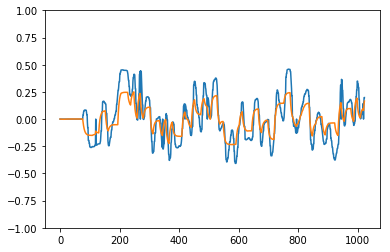

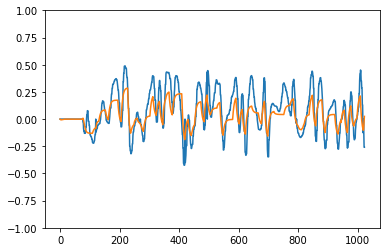

42


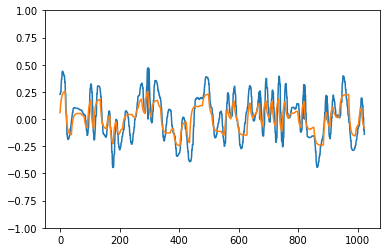

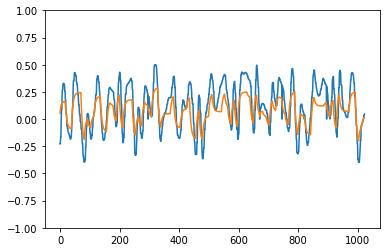

43


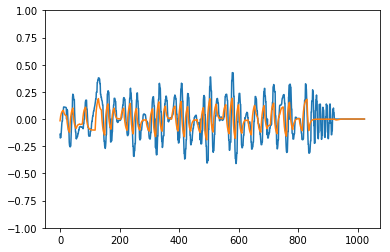

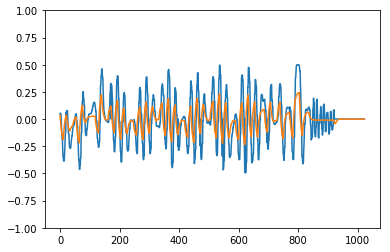

44


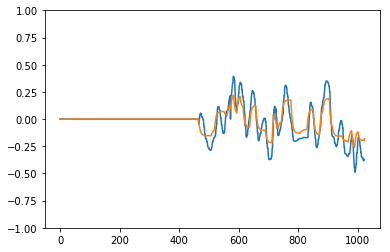

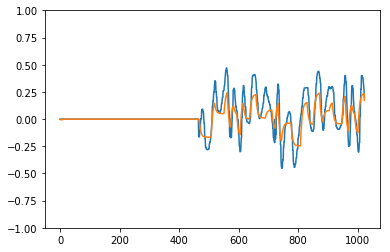

45


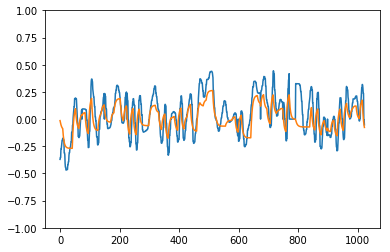

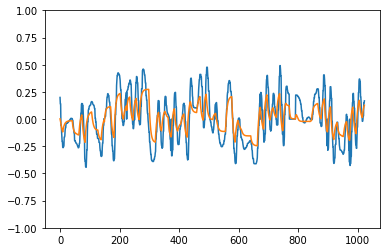

46


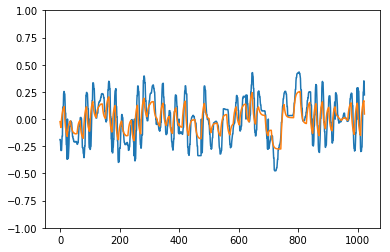

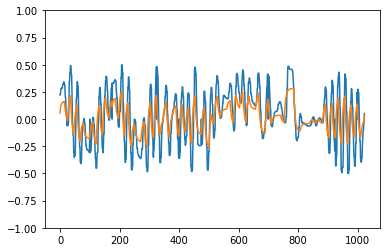

47


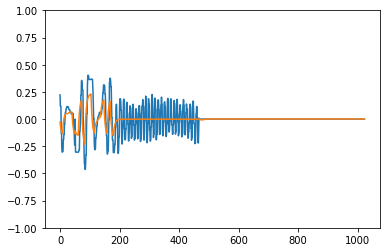

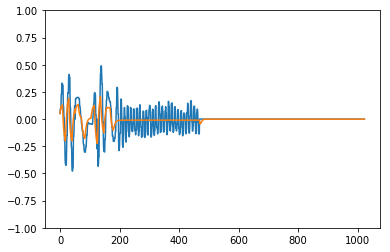

48


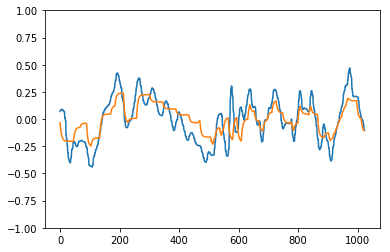

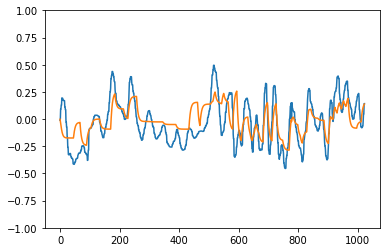

49


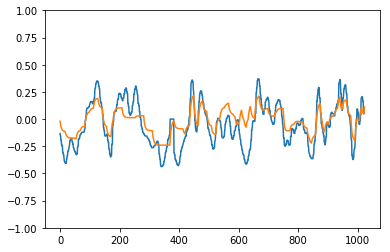

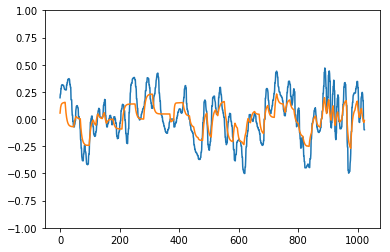

In [22]:
predicted = model.predict(X)

for i in range(50):#len(predicted)):
    print(i)
    plot_info([y[i], predicted[i]])

In [25]:
# %matplotlib notebook

BEATMAPS_FOLDER = 'C:\\Program Files (x86)\\Jogos\\osu!\\Songs\\'
BEATMAP = glob(BEATMAPS_FOLDER + "\\**\\*Daybreak*Horizon[]]*.osu")[0]
#BEATMAP = glob(BEATMAPS_FOLDER + "\\**\\*Imprinting*9.5*.osu")[0]

beatmap = osu.beatmap.load(BEATMAP)

xx = osulearn.create_training_data([(beatmap, None)])
predicted = model.predict(xx)

np.save('osu/replay.npy', np.concatenate(predicted))
print("Done.")

# n = 85

# j = 0
# for i in range(len(predicted[n])):
#     if len(replay_training_set[n][1].data) > i + j:
#         w = replay_training_set[n][1].data[i + j][0]
#         while w < 0 and len(replay_training_set[n][1].data) > i + j + 1:
#             j += 1
#             w = replay_training_set[n][1].data[i + j][0]
#     else:
#         w = 0
        
#     cx, cy = predicted[n][i]
#     replay_data.append([w, cx * 512 + 256, cy * 384 + 192, 0])
    
# osu.replay.preview(replay_training_set[n][0], [replay_data, replay_training_set[n][1].data])
# #osu.replay.preview(replay_training_set[n][0], replay_training_set[n][1].data)

DAYBREAK FRONTLINE
Done.
